# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
# from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,20)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
import sklearn
print(sklearn.__version__)

0.19.1


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
#Random check of the available values for CAMEO_DEUG_2015 before NaN transformation
print(azdias.CAMEO_DEUG_2015.unique())

[nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("The shape of azidias df is {}".format(azdias.shape))
azdias.head()

The shape of azidias df is (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
print("The shape of feature_information df is {}".format(feat_info.shape))
feat_info.head()

The shape of feature_information df is (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
#Check the available indicator types of missing or unkonw values
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
# Transform -1, 0 to int and keep X and XX as string
def int_transformer(inp_str):
    converted = []
    if 'X' not in inp_str:
        converted.append(int(inp_str))
    else: 
        converted.append(inp_str)
    return converted

for index, row in feat_info.iterrows():
    missing_values = row['missing_or_unknown'].replace('[', '')
    missing_values = missing_values.replace(']', '')
    if missing_values != '': #In case of not []
        missing_values_list = list(missing_values.split(',')) #Get each value as string '-1' or '0' or 'XX'
        missing_values_list = list(map(int_transformer, missing_values_list)) #Trasnform -1,0 and 9 to int (Keep 'X', 'XX')
        azdias[row['attribute']].replace(to_replace=missing_values_list, value=np.nan, inplace=True) #Replace missing value by NaN        

In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
#check again the available values for CAMEO_DEUG_2015 after NaN transformation (No 'X' is found now)
print(azdias.CAMEO_DEUG_2015.unique())

[nan '8' '4' '2' '6' '1' '9' '5' '7' '3']


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<Container object of 85 artists>

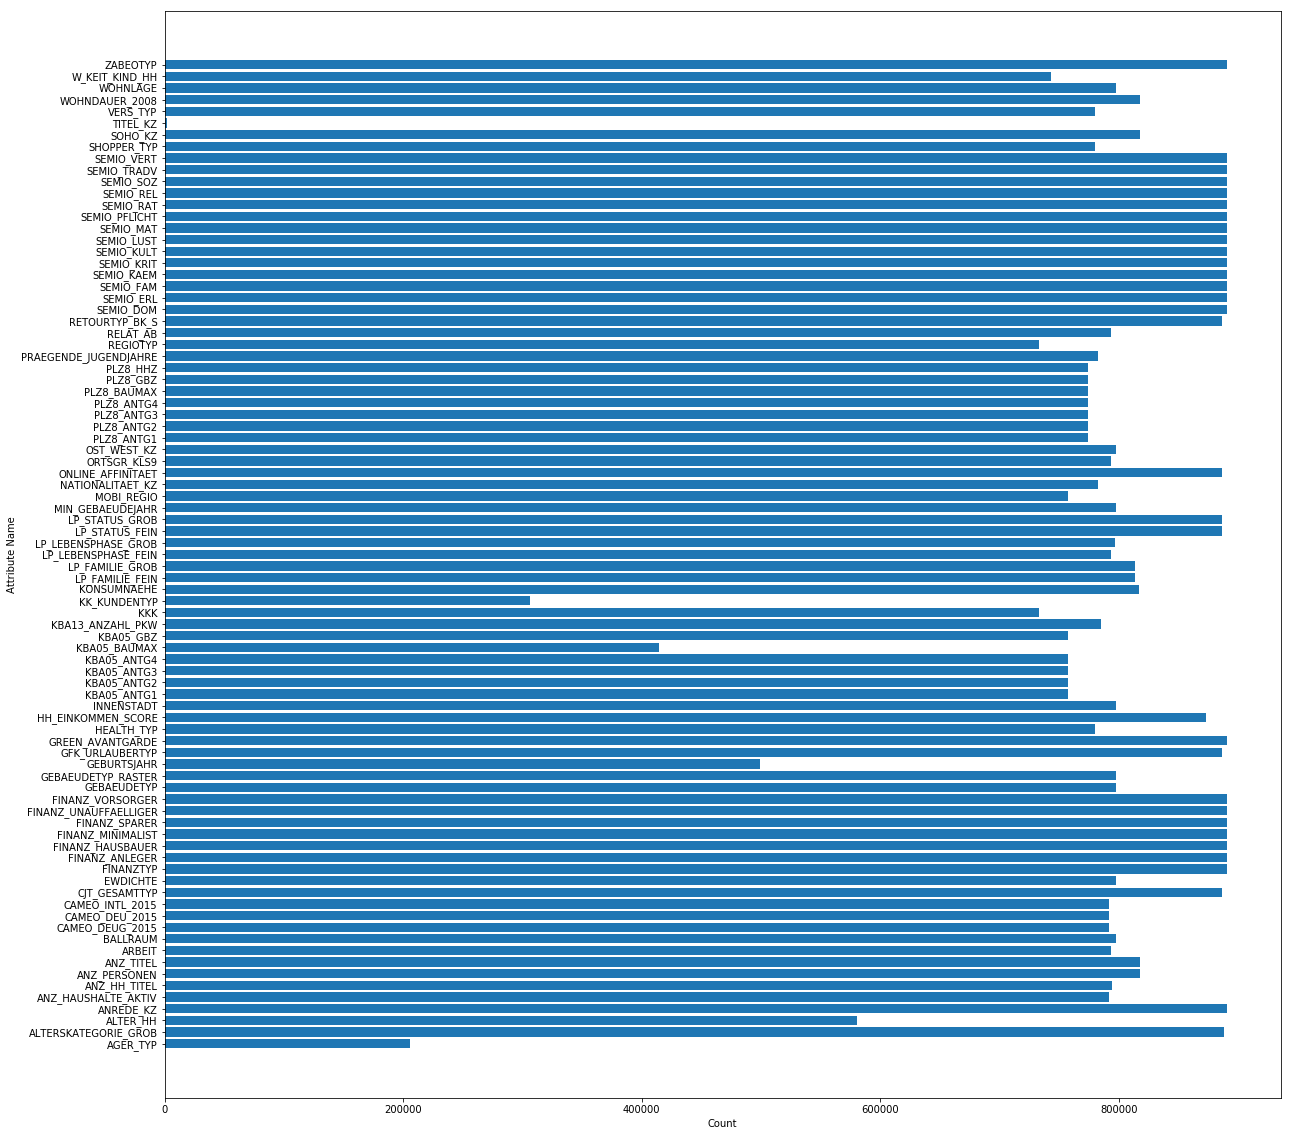

In [65]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Labeling the axes
plt.xlabel('Count')
plt.ylabel('Attribute Name')

# Dsiplay the plot
plt.rcParams['figure.figsize'] = (20,20)
plt.barh(azdias.count().index, azdias.count().values )
# plt.show()

The code in the next cell is to identify all the attributes with missing values > 30%. 

In [12]:
# Investigate patterns in the amount of missing data in each column.
total_rows = azdias.shape[0]
#Check the attributes with missing values > 30%
missing_att_more_than_30 = []
complete_data = []
indices = azdias.count().index
values = azdias.count().values
for attribute, count in zip(indices, values):
    print("The missing % in {} is: {:.3f}".format(attribute,(1-count/total_rows)))
    if count/total_rows == 1:
        complete_data.append(attribute)
    if count/total_rows < 0.70:
        missing_att_more_than_30.append(attribute)
print("Attributes with 100% availability {}".format(complete_data))
print("Needs to be removed {}".format(missing_att_more_than_30))

The missing % in AGER_TYP is: 0.770
The missing % in ALTERSKATEGORIE_GROB is: 0.003
The missing % in ANREDE_KZ is: 0.000
The missing % in CJT_GESAMTTYP is: 0.005
The missing % in FINANZ_MINIMALIST is: 0.000
The missing % in FINANZ_SPARER is: 0.000
The missing % in FINANZ_VORSORGER is: 0.000
The missing % in FINANZ_ANLEGER is: 0.000
The missing % in FINANZ_UNAUFFAELLIGER is: 0.000
The missing % in FINANZ_HAUSBAUER is: 0.000
The missing % in FINANZTYP is: 0.000
The missing % in GEBURTSJAHR is: 0.440
The missing % in GFK_URLAUBERTYP is: 0.005
The missing % in GREEN_AVANTGARDE is: 0.000
The missing % in HEALTH_TYP is: 0.125
The missing % in LP_LEBENSPHASE_FEIN is: 0.110
The missing % in LP_LEBENSPHASE_GROB is: 0.106
The missing % in LP_FAMILIE_FEIN is: 0.087
The missing % in LP_FAMILIE_GROB is: 0.087
The missing % in LP_STATUS_FEIN is: 0.005
The missing % in LP_STATUS_GROB is: 0.005
The missing % in NATIONALITAET_KZ is: 0.122
The missing % in PRAEGENDE_JUGENDJAHRE is: 0.121
The missing % i

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_reduced = azdias.drop(missing_att_more_than_30, axis=1)
azdias_reduced.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

* There are some patterns in the missing values. For example, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER have almost the same missing percentage. This can be noticed in other categories according to Data_Dictionary file. 

* For the removed values, I removed the attributes with missing values more than 30%. This is mainly becuase if we want to do data imputation this will gives us more reliable results. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

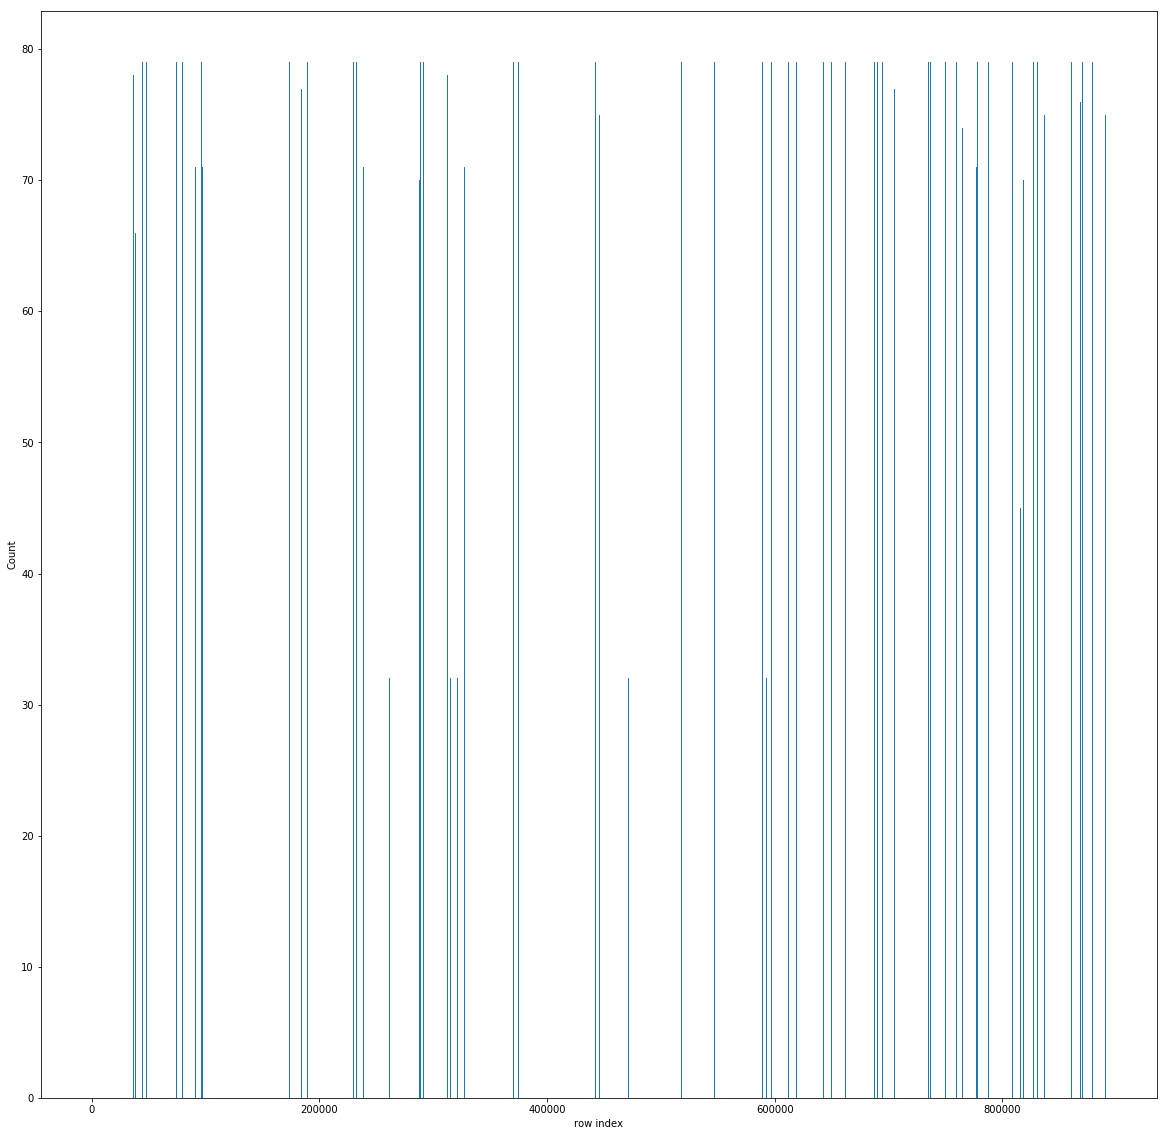

In [14]:
# How much data is missing in each row of the dataset?
# Labeling the axes
plt.xlabel('row index')
plt.ylabel('Count')

# Dsiplay the plot
plt.rcParams['figure.figsize'] = (13,13)
sub_sample = azdias_reduced.sample(frac=0.08) #0.1
plt.bar(sub_sample.count(axis='columns').index, sub_sample.count(axis='columns').values)
plt.show()

In [15]:
#Check the ROWS with more than 5 missing attributes
rows_with_missing_values = [] 
indices = azdias_reduced.count(axis='columns').index
values = azdias_reduced.count(axis='columns').values
for row_idx, count in zip(indices, values):
    if count < 74: 
        rows_with_missing_values.append(row_idx)

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
print("The number of rows with more than 5 missing attrbutes {}".format(len(rows_with_missing_values)))
azdias_reduced_with_missing_rows = pd.DataFrame(azdias_reduced.iloc[rows_with_missing_values])
azdias_reduced_with_missing_rows.head()

The number of rows with more than 5 missing attrbutes 171597


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,3.0,1,6.0,5,3,4,2,4,1,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0
13,1.0,2,5.0,1,4,3,5,5,2,1,...,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0


In [17]:
#Keep only the rows with < 5 missing attributes
azdias_reduced.drop(rows_with_missing_values, axis=0, inplace=True)
azdias_reduced.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_comparision(class_name):
    fig, ax =plt.subplots(1,2)
    fig.suptitle('Complete VS. Missing for {} attribute'.format(class_name))
    plt.rcParams['figure.figsize'] = (6,6)
    sns.countplot(data=azdias_reduced, ax=ax[0], x=class_name)
    sns.countplot(data=azdias_reduced_with_missing_rows, ax=ax[1], x=class_name)
    ax[0].set_title('{} Complete'.format(class_name))
    ax[1].set_title('{} Missing'.format(class_name))
    fig.show()


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


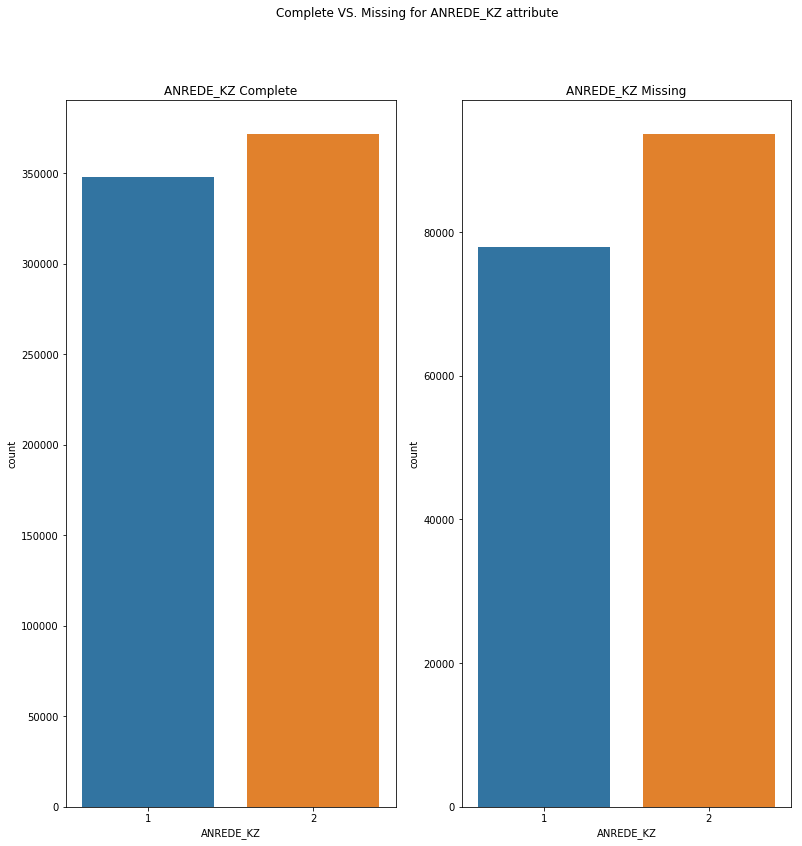

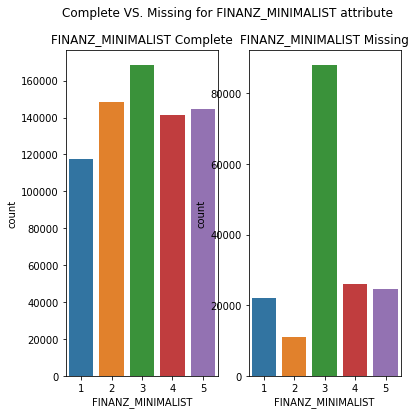

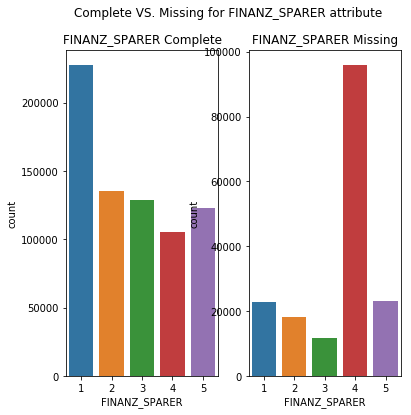

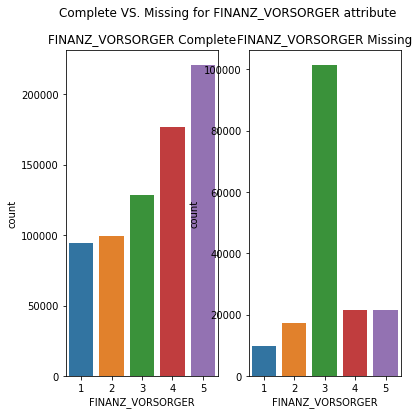

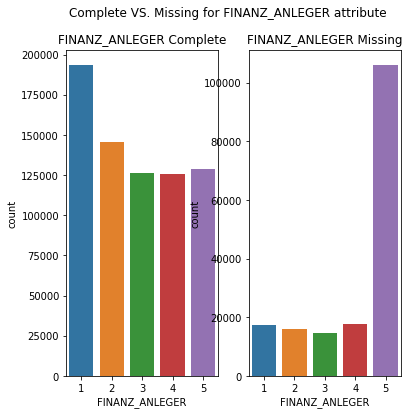

In [19]:
for attribute in complete_data[:5]:
    plot_comparision(attribute)

#### Discussion 1.1.3: Assess Missing Data in Each Row

It is clearly noticable that for almost all the attributes in the rows with missing values have different distributions of thier same classes in the complete dataset. Hence, furthure investigation for this subset of data is needed.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
feat_info.type.unique()    

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [21]:
features_type = {'categorical':[], 'ordinal':[], 'numeric':[], 'mixed':[], 'interval':[]}
for attribute_name in azdias_reduced:
    features_type[feat_info[feat_info.attribute == attribute_name].type.values[0]].append(attribute_name)

#Print the number of features from each data type
for key in features_type:
    print("The number of {} variable is {}".format(key, len(features_type[key])))

The number of categorical variable is 18
The number of ordinal variable is 49
The number of numeric variable is 6
The number of mixed variable is 6
The number of interval variable is 0


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for cat_attribute in features_type['categorical']:
    print("The unique values of {} are {}".format(cat_attribute, azdias_reduced[cat_attribute].unique()))

The unique values of ANREDE_KZ are [2 1]
The unique values of CJT_GESAMTTYP are [ 5.  3.  2.  4.  1.  6.]
The unique values of FINANZTYP are [1 5 2 4 6 3]
The unique values of GFK_URLAUBERTYP are [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   2.   6.]
The unique values of GREEN_AVANTGARDE are [0 1]
The unique values of LP_FAMILIE_FEIN are [  5.   1.  10.   2.  nan   7.  11.   8.   4.   6.   9.   3.]
The unique values of LP_FAMILIE_GROB are [  3.   1.   5.   2.  nan   4.]
The unique values of LP_STATUS_FEIN are [  2.   3.   4.   1.  10.   8.   9.   5.   6.   7.]
The unique values of LP_STATUS_GROB are [ 1.  2.  5.  4.  3.]
The unique values of NATIONALITAET_KZ are [  1.   2.  nan   3.]
The unique values of SHOPPER_TYP are [  3.   2.   0.   1.  nan]
The unique values of SOHO_KZ are [ 1.  0.]
The unique values of VERS_TYP are [  2.   1.  nan]
The unique values of ZABEOTYP are [5 4 1 6 3 2]
The unique values of GEBAEUDETYP are [ 8.  1.  3.  6.  2.  4.  5.]
The unique values of OST_WE

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.

#Encode OST_WEST_KZ variable into 0 or 1: 
print(azdias_reduced['OST_WEST_KZ'].unique())
azdias_reduced['OST_WEST_KZ'] = azdias_reduced['OST_WEST_KZ'].map({'W':0, 'O':1})
print(azdias_reduced['OST_WEST_KZ'].unique())

['W' 'O']
[0 1]


In [24]:
three_or_more_cat = []
for cat_attribute in features_type['categorical']:
    if len(azdias_reduced[cat_attribute].unique()) >= 3:
        three_or_more_cat.append(cat_attribute)
df_remove = pd.DataFrame(azdias_reduced[three_or_more_cat])
print(df_remove.shape)
df_remove.head()

(719624, 14)


,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,VERS_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,2.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0,5,1.0,4,4C
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,2.0,4,1.0,6,6B
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,2.0,4,1.0,8,8C
6,5.0,4,12.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4,1.0,4,4A


In [25]:
azdias_reduced = azdias_reduced.drop(three_or_more_cat, axis=1)
azdias_reduced.shape

(719624, 65)

#### Discussion 1.2.1: Re-Encode Categorical Features

For categorical data, there are 18 features. I kept the ones with 2 categories only. The OST_WEST_KZ feature values are reencoded to 0 or 1. The total number of dropped values are 14 (It is better to use pd.get_dummies() or HotEncoder() but for simplicity I chose to drop these values.)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_reduced['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias_reduced['PRAEGENDE_JUGENDJAHRE']
azdias_reduced['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias_reduced['PRAEGENDE_JUGENDJAHRE']

#Values to be replaced
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

In [27]:
azdias_reduced['PRAEGENDE_JUGENDJAHRE_Movement'].replace(movement_dict, inplace=True)
azdias_reduced['PRAEGENDE_JUGENDJAHRE_Decade'].replace(decade_dict, inplace=True)

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_reduced['CAMEO_INTL_2015_Wealthy'] = azdias_reduced['CAMEO_INTL_2015']
azdias_reduced['CAMEO_INTL_2015_Life_Stage'] = azdias_reduced['CAMEO_INTL_2015']

#Values to be replaced
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}


In [29]:
azdias_reduced['CAMEO_INTL_2015_Wealthy'].replace(wealth_dict, inplace=True)
azdias_reduced['CAMEO_INTL_2015_Life_Stage'].replace(life_stage_dict, inplace=True)

In [30]:
azdias_reduced = azdias_reduced.drop('CAMEO_INTL_2015' ,axis=1)
azdias_reduced = azdias_reduced.drop('PRAEGENDE_JUGENDJAHRE' ,axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
* I reengineered two features: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 by replacing each value with teh new suitable one (Last 4 code cells). 
* For the rest of the mixed values I decide to keep them without modification for the purpose of this project.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [31]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [32]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_reduced.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealthy,CAMEO_INTL_2015_Life_Stage
count,718093.000000,719624.000000,719624.000000,719624.000000,719624.000000,719624.00000,719624.000000,719624.000000,719624.000000,704814.000000,...,719624.000000,719624.000000,719624.000000,716017.000000,716093.000000,716017.000000,712260.000000,712260.000000,716567.000000,716567.000000
mean,2.793277,1.516453,3.065229,2.669370,3.458492,2.79274,2.562273,3.165282,0.225177,2.213222,...,1.961076,3.612632,3.366475,3.187096,5.331851,3.091048,0.772495,4.316052,3.293441,2.873167
std,1.031134,0.499730,1.361379,1.474188,1.387388,1.45717,1.375376,1.377705,0.417699,0.755041,...,1.466445,0.969788,1.111998,0.993635,2.299299,1.356006,0.419222,1.460527,1.466563,1.494214
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.00000,1.000000,2.000000,0.000000,2.000000,...,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000,1.000000,3.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,2.000000,4.000000,3.00000,2.000000,3.000000,0.000000,2.000000,...,1.000000,3.000000,3.000000,3.000000,5.000000,3.000000,1.000000,4.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.00000,4.000000,4.000000,0.000000,3.000000,...,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000,1.000000,6.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,1.000000,3.000000,...,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,1.000000,6.000000,5.000000,5.000000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
def missing_to_NaNs(df, feat_info):
    for index, row in feat_info.iterrows():
        missing_values = row['missing_or_unknown'].replace('[', '')
        missing_values = missing_values.replace(']', '')
        if missing_values != '': #In case of not []
            missing_values_list = list(missing_values.split(',')) #Get each value as string '-1' or '0' or 'XX'
            missing_values_list = list(map(int_transformer, missing_values_list)) #Trasnform -1,0 and 9 to int (Keep 'X', 'XX')
            df[row['attribute']].replace(to_replace=missing_values_list, value=np.nan, inplace=True) #Replace missing value by NaN        
    return df

def remove_cols_rows(df, missing_att_more_than_30):
    # Investigate patterns in the amount of missing data in each column.
    total_rows = df.shape[0]
    #Drop the attributes with missing values > 30%
    df_reduced = df.drop(missing_att_more_than_30, axis=1)
    
    #Remove rows
    rows_with_missing_values = [] 
    indices = df_reduced.count(axis='columns').index
    values = df_reduced.count(axis='columns').values
    for row_idx, count in zip(indices, values):
        if count < 74: 
            rows_with_missing_values.append(row_idx)
            
    df_reduced.drop(rows_with_missing_values, axis=0, inplace=True)
    return df_reduced

def select_reencode_engineer(df_reduced, feat_info):
    features_type = {'categorical':[], 'ordinal':[], 'numeric':[], 'mixed':[], 'interval':[]}
    for attribute_name in df_reduced: #to calculate the number of each dat type in the features
        features_type[feat_info[feat_info.attribute == attribute_name].type.values[0]].append(attribute_name)

    
    #Encode OST_WEST_KZ variable into 0 or 1: 
    df_reduced['OST_WEST_KZ'] = df_reduced['OST_WEST_KZ'].map({'W':0, 'O':1})
    
    three_or_more_cat = []
    for cat_attribute in features_type['categorical']:
        if len(df_reduced[cat_attribute].unique()) >= 3:
            three_or_more_cat.append(cat_attribute)
    df_reduced = df_reduced.drop(three_or_more_cat, axis=1)

    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df_reduced['PRAEGENDE_JUGENDJAHRE_Movement'] = df_reduced['PRAEGENDE_JUGENDJAHRE']
    df_reduced['PRAEGENDE_JUGENDJAHRE_Decade'] = df_reduced['PRAEGENDE_JUGENDJAHRE']

    #Values to be replaced
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    
    df_reduced['PRAEGENDE_JUGENDJAHRE_Movement'].replace(movement_dict, inplace=True)
    df_reduced['PRAEGENDE_JUGENDJAHRE_Decade'].replace(decade_dict, inplace=True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df_reduced['CAMEO_INTL_2015_Wealthy'] = df_reduced['CAMEO_INTL_2015']
    df_reduced['CAMEO_INTL_2015_Life_Stage'] = df_reduced['CAMEO_INTL_2015']

    #Values to be replaced
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}

    df_reduced['CAMEO_INTL_2015_Wealthy'].replace(wealth_dict, inplace=True)
    df_reduced['CAMEO_INTL_2015_Life_Stage'].replace(life_stage_dict, inplace=True)
    
    df_reduced = df_reduced.drop('CAMEO_INTL_2015' ,axis=1)
    df_reduced = df_reduced.drop('PRAEGENDE_JUGENDJAHRE' ,axis=1)
    
    return df_reduced

def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print("convert missing value codes into NaNs, ...")
    df = missing_to_NaNs(df, feat_info)
    
    # remove selected columns and rows, ...
    print("removing selected columns and rows, ...")
    df_reduced = remove_cols_rows(df, missing_att_more_than_30)
    
    # select, re-encode, and engineer column values.
    print("select, re-encode, and engineer column values...")
    df_reduced = select_reencode_engineer(df_reduced, feat_info)
    # Return the cleaned dataframe.
    
    return df_reduced

In [34]:
customer_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customer_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [35]:
customer_df = clean_data(customer_df, feat_info)
customer_df.head()

convert missing value codes into NaNs, ...
removing selected columns and rows, ...
select, re-encode, and engineer column values...


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealthy,CAMEO_INTL_2015_Life_Stage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,5.0,5.0,1.0,2.0,1.0,0.0,2.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,3.0,3.0,2.0,3.0,5.0,3.0,0.0,2.0,3.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,2.0,3.0,3.0,3.0,5.0,1.0,1.0,4.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,0.0,2.0,3.0,4.0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,1.0,5.0,5.0,2.0,3.0,2.0,0.0,2.0,2.0,3.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
#Imputing numeric features with mean value...
#We can use features_type['numeric'] because we did not drop any attribute of it
print(azdias_reduced[features_type['numeric']].isnull().sum())
imputer_numeric = Imputer(strategy="mean", axis=0)
azdias_reduced[features_type['numeric']] = imputer_numeric.fit_transform(azdias_reduced[features_type['numeric']])
print(azdias_reduced[features_type['numeric']].isnull().sum())

ANZ_PERSONEN              0
ANZ_TITEL                 0
ANZ_HAUSHALTE_AKTIV    2645
ANZ_HH_TITEL            603
MIN_GEBAEUDEJAHR          0
KBA13_ANZAHL_PKW        642
dtype: int64
ANZ_PERSONEN           0
ANZ_TITEL              0
ANZ_HAUSHALTE_AKTIV    0
ANZ_HH_TITEL           0
MIN_GEBAEUDEJAHR       0
KBA13_ANZAHL_PKW       0
dtype: int64


In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#Imputing ordinal and mixed values with the most frequent value; since mean doesn't make sense here
print("Does it have NaN values? {}".format(azdias_reduced.isnull().values.any()))
imputer_non_numeric = Imputer(strategy="most_frequent", axis=0)
azdias_reduced = pd.DataFrame(imputer_non_numeric.fit_transform(azdias_reduced.copy()), index=azdias_reduced.index, columns=azdias_reduced.columns)
print("Does it have NaN values? {}".format(azdias_reduced.isnull().values.any()))

Does it have NaN values? True
Does it have NaN values? False


In [38]:
azdias_reduced.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealthy,CAMEO_INTL_2015_Life_Stage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,2.0,4.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,1.0,5.0,2.0,2.0


In [39]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_reduced = pd.DataFrame(scaler.fit_transform(azdias_reduced.copy()), index=azdias_reduced.index, columns=azdias_reduced.columns)
azdias_reduced.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealthy,CAMEO_INTL_2015_Life_Stage
1,-1.741337,0.967618,-1.517013,1.580959,-1.051251,1.514759,1.045335,1.331721,-0.539090,1.019923,...,-0.655378,1.430590,0.569719,-0.192557,-0.143965,0.672332,0.539090,1.139336,1.157846,-1.246795
2,0.200259,0.967618,-1.517013,0.902619,-1.772031,-0.544028,0.318260,1.331721,1.854978,1.019923,...,-0.655378,0.399436,0.569719,-0.192557,-0.143965,-0.806282,-1.854978,1.139336,-0.886242,0.758547
4,0.200259,-1.033466,0.686636,0.224279,0.390308,-1.230290,0.318260,-0.845814,-0.539090,1.019923,...,0.026543,-0.631719,-0.329565,0.814694,0.291999,1.411639,0.539090,-0.227827,0.476484,0.090100
5,-1.741337,0.967618,-0.047914,-1.132401,1.111087,-0.544028,-0.408814,1.331721,-0.539090,1.019923,...,-0.655378,1.430590,1.469002,-1.199807,-1.015893,-0.066975,0.539090,-1.594989,1.157846,0.758547
6,-0.770539,0.967618,-1.517013,1.580959,-1.772031,1.514759,1.045335,-0.119969,-0.539090,-0.303645,...,-0.655378,1.430590,1.469002,0.814694,0.291999,-0.066975,0.539090,0.455755,-0.886242,-0.578347


### Discussion 2.1: Apply Feature Scaling

For feature scaling, I followed the following steps:
1. Filling NaN numeric values with mean value for each column.
2. Filling NaN non-numeric values (Categorical, mixed...) with the most frequent value. I didn't use mean since we are dealing with categories and not real numerics. 
3. After data imputation, I scaled all the dataset using StandardScaler. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
pca = PCA()
azdias_reduced_pca = pca.fit_transform(azdias_reduced)
azdias_reduced_pca.shape

(719624, 67)

In [41]:
print(pca.components_.shape)
print(pca.explained_variance_)
print(pca.explained_variance_.shape)
print(pca.n_components_)

(67, 67)
[  1.18963834e+01   8.84559208e+00   6.09131446e+00   3.85579669e+00
   2.81454265e+00   2.23359991e+00   2.06618139e+00   1.69717577e+00
   1.48995637e+00   1.40369928e+00   1.33590749e+00   1.21216056e+00
   1.19888297e+00   1.08987843e+00   1.04527006e+00   9.99809396e-01
   9.21402672e-01   9.09246398e-01   8.44453918e-01   8.38200549e-01
   7.76181097e-01   7.55467832e-01   7.52632481e-01   7.08659089e-01
   6.36645517e-01   5.88265961e-01   5.08617895e-01   5.06587791e-01
   4.85878029e-01   4.63770963e-01   4.54797872e-01   4.34484939e-01
   4.19764797e-01   4.03418968e-01   3.96101673e-01   3.77477309e-01
   3.45248468e-01   3.06205561e-01   2.92203725e-01   2.73616833e-01
   2.69707904e-01   2.57852076e-01   2.52570000e-01   2.48960892e-01
   2.40216271e-01   2.35181691e-01   2.27729119e-01   2.20426430e-01
   2.04821588e-01   1.99752378e-01   1.92016550e-01   1.83288926e-01
   1.69525099e-01   1.67554651e-01   1.58457692e-01   1.44203233e-01
   1.42677620e-01   1.367

Text(0.5,0,'Number of components')

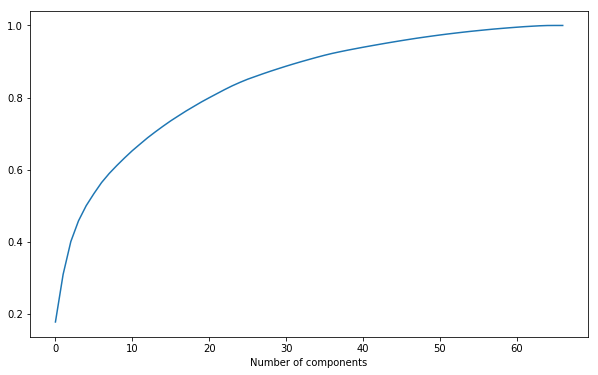

In [42]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_)) #or 1-pca.explained_variance_ratio_ (because it is a ratio)
plt.xlabel("Number of components")

In [43]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

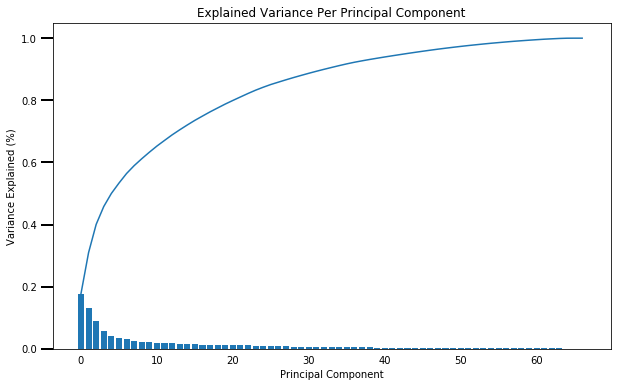

In [44]:
scree_plot(pca)

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.
# I will use 40 components 
pca = PCA(n_components=40)
azdias_reduced_pca = pca.fit_transform(azdias_reduced)
azdias_reduced_pca.shape

(719624, 40)

In [46]:
print(pca.components_.shape)
print(pca.n_components_)

(40, 67)
40


### Discussion 2.2: Perform Dimensionality Reduction

Q) How many principal components / transformed features are you retaining for the next step of the analysis?

A) I chose 40 components because the significant variance is around that number

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [47]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i, df):
    df_weight = pd.DataFrame(data=pca.components_, columns=list(df.columns))
    weight = df_weight.iloc[i].sort_values(ascending=False)
    return weight

In [48]:
pca_weight0 = pca_weights(pca, 0, azdias_reduced)
pca_weight0

PLZ8_ANTG3                        0.222507
PLZ8_ANTG4                        0.216736
PLZ8_BAUMAX                       0.212426
CAMEO_INTL_2015_Wealthy           0.198926
HH_EINKOMMEN_SCORE                0.195763
ORTSGR_KLS9                       0.194341
EWDICHTE                          0.191420
FINANZ_HAUSBAUER                  0.158923
KBA05_ANTG4                       0.150383
PLZ8_ANTG2                        0.149624
ARBEIT                            0.140047
ANZ_HAUSHALTE_AKTIV               0.133289
KBA05_ANTG3                       0.132143
RELAT_AB                          0.130702
FINANZ_SPARER                     0.118251
PRAEGENDE_JUGENDJAHRE_Movement    0.105440
SEMIO_PFLICHT                     0.088173
SEMIO_REL                         0.085182
PRAEGENDE_JUGENDJAHRE_Decade      0.079991
SEMIO_RAT                         0.074354
SEMIO_TRADV                       0.070650
SEMIO_MAT                         0.067684
SEMIO_FAM                         0.064347
REGIOTYP   

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight1 = pca_weights(pca, 1, azdias_reduced)
pca_weight1

ALTERSKATEGORIE_GROB            0.268047
FINANZ_VORSORGER                0.239345
SEMIO_ERL                       0.236346
SEMIO_LUST                      0.188764
RETOURTYP_BK_S                  0.167546
SEMIO_KRIT                      0.117140
W_KEIT_KIND_HH                  0.112063
SEMIO_KAEM                      0.105013
FINANZ_HAUSBAUER                0.098306
FINANZ_MINIMALIST               0.088703
ANREDE_KZ                       0.087138
EWDICHTE                        0.072448
ORTSGR_KLS9                     0.071513
PLZ8_ANTG3                      0.070730
PLZ8_ANTG4                      0.067621
WOHNDAUER_2008                  0.064365
SEMIO_DOM                       0.063654
PLZ8_BAUMAX                     0.062676
KBA05_ANTG4                     0.053282
ARBEIT                          0.051415
RELAT_AB                        0.049957
CAMEO_INTL_2015_Wealthy         0.049570
PLZ8_ANTG2                      0.048200
ANZ_HAUSHALTE_AKTIV             0.046532
KBA05_ANTG3     

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight2 = pca_weights(pca, 2,azdias_reduced)
pca_weight2

SEMIO_VERT                        0.349138
SEMIO_SOZ                         0.263650
SEMIO_FAM                         0.250537
SEMIO_KULT                        0.232109
FINANZ_MINIMALIST                 0.162923
RETOURTYP_BK_S                    0.114400
FINANZ_VORSORGER                  0.098875
W_KEIT_KIND_HH                    0.084578
ALTERSKATEGORIE_GROB              0.081616
SEMIO_REL                         0.076371
SEMIO_LUST                        0.070311
GREEN_AVANTGARDE                  0.056342
SEMIO_MAT                         0.053975
ORTSGR_KLS9                       0.044115
EWDICHTE                          0.043603
PLZ8_BAUMAX                       0.043240
PLZ8_ANTG4                        0.040819
PLZ8_ANTG3                        0.039719
WOHNDAUER_2008                    0.036117
ARBEIT                            0.029020
RELAT_AB                          0.027617
PLZ8_ANTG2                        0.026579
KBA05_ANTG4                       0.022821
ANZ_HAUSHAL

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

For the first pca component, we can ntice the following: 
1. PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX are the most features in the same direction of the pc. However, KBA05_ANTG1, PLZ8_ANTG1, MOBI_REGIO are in the opposite direction of the first pc
2. Also if we look at the first component, we can expect that the increase of PLZ8_ANTG3 for example will propably leadto increase in PLZ8_ANTG4.
3. The increase in PLZ8_ANTG4 will most likely reflect in a decrease in KBA05_ANTG1. 
4. The same logic will apply for the different components. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    print("Finish calculations for k-means with {} clusters".format(center))
    return score    

Finish calculations for k-means with 1 clusters
Finish calculations for k-means with 4 clusters
Finish calculations for k-means with 7 clusters
Finish calculations for k-means with 10 clusters
Finish calculations for k-means with 13 clusters
Finish calculations for k-means with 16 clusters
Finish calculations for k-means with 19 clusters
Finish calculations for k-means with 22 clusters
Finish calculations for k-means with 25 clusters
Finish calculations for k-means with 28 clusters


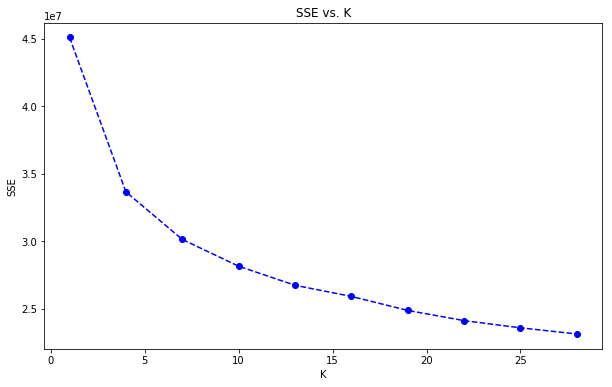

In [52]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,29,3)) 

for center in centers:
    scores.append(get_kmeans_score(azdias_reduced_pca, center))

plt.figure(figsize=(10, 6));
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#instantiate kmeans
kmeans = KMeans(n_clusters=26)
# Then fit the model to your data using the fit method
model = kmeans.fit(azdias_reduced_pca)

In [54]:
azdias_pred = model.predict(azdias_reduced_pca)
print(azdias_pred.shape)

(719624,)


### Discussion 3.1: Apply Clustering to General Population

Q) Into how many clusters have you decided to segment the population?

A) The best k found using the elbow method was k=26

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [55]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Data cleaning
customers = clean_data(customers, feat_info)
customers.head()

convert missing value codes into NaNs, ...
removing selected columns and rows, ...
select, re-encode, and engineer column values...


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealthy,CAMEO_INTL_2015_Life_Stage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,5.0,5.0,1.0,2.0,1.0,0.0,2.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,3.0,3.0,2.0,3.0,5.0,3.0,0.0,2.0,3.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,2.0,3.0,3.0,3.0,5.0,1.0,1.0,4.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,0.0,2.0,3.0,4.0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,1.0,5.0,5.0,2.0,3.0,2.0,0.0,2.0,2.0,3.0


In [57]:
#Data Imputation & Feature scaling 
print(customers[features_type['numeric']].isnull().sum())
customers[features_type['numeric']] = imputer_numeric.transform(customers[features_type['numeric']])
print(customers[features_type['numeric']].isnull().sum())

#Imputing ordinal and mixed values with the most frequent value; since mean doesn't make sense here
print("Does it have NaN values? {}".format(customers.isnull().values.any()))
customers = pd.DataFrame(imputer_non_numeric.transform(customers.copy()), index=customers.index, columns=customers.columns)
print("Does it have NaN values? {}".format(customers.isnull().values.any()))


# Apply feature scaling to the general population demographics data.
customers = pd.DataFrame(scaler.transform(customers.copy()), index=customers.index, columns=customers.columns)
customers.head()

ANZ_PERSONEN             0
ANZ_TITEL                0
ANZ_HAUSHALTE_AKTIV    345
ANZ_HH_TITEL           214
MIN_GEBAEUDEJAHR         0
KBA13_ANZAHL_PKW        41
dtype: int64
ANZ_PERSONEN           0
ANZ_TITEL              0
ANZ_HAUSHALTE_AKTIV    0
ANZ_HH_TITEL           0
MIN_GEBAEUDEJAHR       0
KBA13_ANZAHL_PKW       0
dtype: int64
Does it have NaN values? True
Does it have NaN values? False


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealthy,CAMEO_INTL_2015_Life_Stage
0,1.171057,-1.033466,1.421186,-1.132401,1.111087,-1.230290,-0.408814,-0.845814,1.854978,-1.627214,...,-0.655378,1.430590,1.469002,-2.207057,-1.451857,-1.545589,-1.854978,-1.594989,-1.567605,0.090100
2,1.171057,0.967618,1.421186,-1.132401,1.111087,-1.230290,1.045335,0.605876,1.854978,-0.303645,...,0.708465,-0.631719,-1.228848,-0.192557,-0.143965,-0.066975,-1.854978,-1.594989,-0.204879,0.758547
4,0.200259,-1.033466,-0.047914,-1.132401,0.390308,0.828497,1.772409,-0.845814,-0.539090,1.019923,...,0.026543,-0.631719,-0.329565,-0.192557,-0.143965,-1.545589,0.539090,-0.227827,0.476484,-1.246795
5,0.200259,-1.033466,1.421186,-1.132401,1.111087,-1.230290,-0.408814,-0.119969,1.854978,1.019923,...,-0.655378,1.430590,1.469002,-0.192557,0.727963,1.411639,-1.854978,-1.594989,-0.204879,0.758547
6,1.171057,-1.033466,1.421186,-1.132401,1.111087,-1.230290,-1.135889,-0.845814,1.854978,-0.303645,...,-0.655378,1.430590,1.469002,-1.199807,-1.015893,-0.806282,-1.854978,-1.594989,-0.886242,0.090100


In [58]:
#PCA on customers
customers_pca = pca.transform(customers)
customers_pca.shape

(128989, 40)

In [59]:
#K-means on the customer data
customers_pred = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customers clusters')

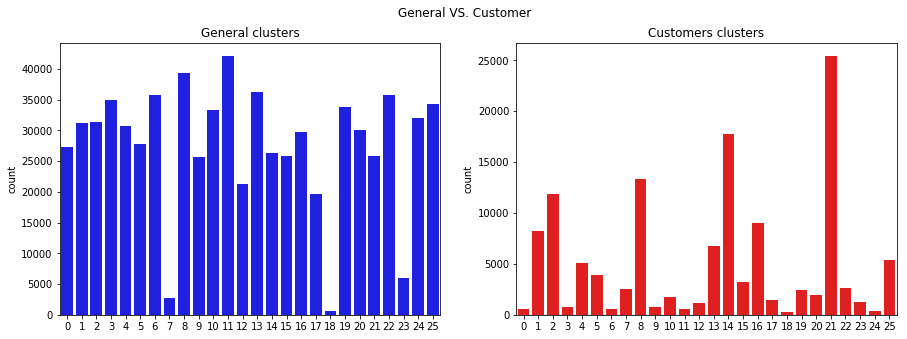

In [60]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
fig.suptitle('General VS. Customer')
sns.countplot(azdias_pred, ax=ax[0], color='b')
sns.countplot(customers_pred, ax=ax[1], color='r')
ax[0].set_title('General clusters')
ax[1].set_title('Customers clusters')

In [61]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
pca_weight3 = pca_weights(pca, 2,customers)
pca_weight3

SEMIO_VERT                        0.349138
SEMIO_SOZ                         0.263650
SEMIO_FAM                         0.250537
SEMIO_KULT                        0.232109
FINANZ_MINIMALIST                 0.162923
RETOURTYP_BK_S                    0.114400
FINANZ_VORSORGER                  0.098875
W_KEIT_KIND_HH                    0.084578
ALTERSKATEGORIE_GROB              0.081616
SEMIO_REL                         0.076371
SEMIO_LUST                        0.070311
GREEN_AVANTGARDE                  0.056342
SEMIO_MAT                         0.053975
ORTSGR_KLS9                       0.044115
EWDICHTE                          0.043603
PLZ8_BAUMAX                       0.043240
PLZ8_ANTG4                        0.040819
PLZ8_ANTG3                        0.039719
WOHNDAUER_2008                    0.036117
ARBEIT                            0.029020
RELAT_AB                          0.027617
PLZ8_ANTG2                        0.026579
KBA05_ANTG4                       0.022821
ANZ_HAUSHAL

In [66]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
pca_weight4 = pca_weights(pca, 8,customers)
pca_weight4

SEMIO_RAT                         0.300018
SEMIO_MAT                         0.292115
SEMIO_TRADV                       0.272740
FINANZ_VORSORGER                  0.256543
RETOURTYP_BK_S                    0.239847
SEMIO_PFLICHT                     0.229756
WOHNDAUER_2008                    0.220618
SEMIO_REL                         0.196066
PRAEGENDE_JUGENDJAHRE_Movement    0.123859
SEMIO_KULT                        0.098503
LP_LEBENSPHASE_FEIN               0.092881
FINANZ_MINIMALIST                 0.091923
LP_LEBENSPHASE_GROB               0.090932
SEMIO_DOM                         0.090858
ANZ_PERSONEN                      0.073139
PLZ8_ANTG1                        0.072069
SEMIO_KAEM                        0.071660
SEMIO_FAM                         0.066007
ANREDE_KZ                         0.063114
FINANZ_HAUSBAUER                  0.063030
ANZ_HH_TITEL                      0.057681
ANZ_HAUSHALTE_AKTIV               0.052209
KBA05_ANTG2                       0.049366
HH_EINKOMME

In [67]:
pca_weight5 = pca_weights(pca, 21,customers)
pca_weight5

GEBAEUDETYP_RASTER                0.422269
MIN_GEBAEUDEJAHR                  0.283376
KONSUMNAEHE                       0.213814
KBA05_ANTG2                       0.173354
FINANZ_HAUSBAUER                  0.169618
PLZ8_ANTG2                        0.168495
FINANZ_VORSORGER                  0.144138
KBA05_ANTG4                       0.091166
WOHNDAUER_2008                    0.087594
KBA05_ANTG1                       0.079907
PLZ8_ANTG3                        0.076165
KBA05_GBZ                         0.074987
MOBI_REGIO                        0.073142
PRAEGENDE_JUGENDJAHRE_Movement    0.068981
ANZ_HAUSHALTE_AKTIV               0.068141
W_KEIT_KIND_HH                    0.067498
CAMEO_INTL_2015_Wealthy           0.065948
ANZ_HH_TITEL                      0.059261
PLZ8_ANTG4                        0.050244
EWDICHTE                          0.049106
ANREDE_KZ                         0.040720
ANZ_PERSONEN                      0.039215
ORTSGR_KLS9                       0.028348
PLZ8_BAUMAX

### Discussion 3.3: Compare Customer Data to Demographics Data
* In this last stage we compared the clusters between general population and customers. Based on the charts given above, it is important to target people in clusters 2,8, 14 and 21 (Overrepresented). 
* Also it is important to notice the features that corrolates with pc in consumers. For example, GEBAEUDETYP_RASTER    ,MIN_GEBAEUDEJAHR in cluster 21. 
* Some underrepresented clusters are: 3, 6,9 and 18 which the company doesn't need to target them. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.